In [1]:
import cv2
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def save_pickle(variable,filename,folder):
    pickle_out=open(str(folder)+"/"+str(filename) + ".pickle","wb")
    pickle.dump(variable,pickle_out)
    pickle_out.close()
    
def load_pickle(filename,folder):
    return pickle.load(open(str(folder)+"/"+str(filename) + ".pickle","rb"))

In [3]:
def normalized_training_test_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=random_state)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [4]:
def PCA_fit(X):
    pca = PCA(n_components=None)
    pca.fit(X)
    eigenvalues=pca.explained_variance_
    explained_variance=pca.explained_variance_ratio_
    return eigenvalues,explained_variance

In [5]:
def PCA_plot(eigenvalues,explained_var):
    print("Eigenvalues:")
    print(eigenvalues)
    print()
    # Get explained variances
    print("Variances (Percentage):")
    print(explained_var * 100)
    print()
    plt.plot(np.cumsum(explained_var * 100))
    plt.xlabel("Number of components (Dimensions)")
    plt.ylabel("Explained variance (%)")
    plt.show()
    return

In [6]:
def PCA_transform(X_train,X_test):
    pca = PCA(0.9,random_state=random_state)
    X1 = pca.fit_transform(X_train)
    X2 = pca.transform(X_test)
    return pd.DataFrame(X1), pd.DataFrame(X2)

In [7]:
def logistic_tuner_model(X_train,X_test,y_train,y_test):
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=random_state,
                                       shuffle=True)
    
    c_values = [100, 10, 1.0, 0.1, 0.01]
    solver=['saga', 'sag','newton-cg', 'lbfgs', 'liblinear']          
    
    param_grid = {'C':c_values,
                  'solver': solver}
    
    random_search = RandomizedSearchCV(LogisticRegression(random_state=random_state),
                                       param_distributions=param_grid,
                                       scoring='roc_auc',
                                       cv=stratified_kfold,
                                       n_jobs=-1,
                                       n_iter=20)
    
    random_result = random_search.fit(X_train, y_train)
    cv_results=random_result.cv_results_    
    y_predict=random_search.predict(X_test)
    y_preds=random_search.predict_proba(X_test)[:,1]
    cv_score = random_search.best_score_
    
    accuracy_table=pd.DataFrame((cv_results["split0_test_score"],
                               cv_results["split1_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split4_test_score"]))    
     
    return random_result,cv_results,cv_score,y_predict,y_test,accuracy_table,y_preds

In [8]:
def rf_tuner_model(X_train,X_test,y_train,y_test):
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=random_state,
                                       shuffle=True)
    
    n_estimators=[200, 400, 600, 800]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth=[4,8,12,16,20]
    criterion=['gini', 'entropy']
            
    param_grid = {'n_estimators':n_estimators,
                  'max_features':max_features,
                  'max_depth':max_depth,
                  'criterion':criterion}
    
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=random_state),
                                       param_distributions=param_grid,
                                       scoring='roc_auc',
                                       cv=stratified_kfold,
                                       n_jobs=-1, 
                                       n_iter=20)
    
    random_result = random_search.fit(X_train, y_train)
    cv_results=random_result.cv_results_    
    y_predict=random_search.predict(X_test)
    y_preds=random_search.predict_proba(X_test)[:,1]
    cv_score = random_search.best_score_
    
    accuracy_table=pd.DataFrame((cv_results["split0_test_score"],
                               cv_results["split1_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split4_test_score"])) 
     
    return random_result,cv_results,cv_score,y_predict,y_test,accuracy_table,y_preds

In [9]:
def svm_tuner_model(X_train,X_test,y_train,y_test):
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=random_state,
                                       shuffle=True)
    
    kernel=['rbf','poly','sigmoid']
    c_values = [0.001,0.1,1,10,100,1000]
    gamma=[1000,100,10,1,0.1,0.01,0.001]
            
    param_grid = {'kernel':kernel,
                  'C':c_values,
                  'gamma':gamma}
    
    random_search = RandomizedSearchCV(svm.SVC(cache_size=500,probability=True,random_state=random_state),
                                       param_distributions=param_grid,
                                       scoring='roc_auc',
                                       cv=stratified_kfold,
                                       n_jobs=-1,
                                       n_iter=20)
    
    random_result = random_search.fit(X_train, y_train)
    cv_results=random_result.cv_results_    
    y_predict=random_search.predict(X_test)
    y_preds=random_search.predict_proba(X_test)[:,1]
    cv_score = random_search.best_score_
    
    accuracy_table=pd.DataFrame((cv_results["split0_test_score"],
                               cv_results["split1_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split4_test_score"])) 
     
    return random_result,cv_results,cv_score,y_predict,y_test,accuracy_table,y_preds

In [10]:
def classifier_analysis(classifier):
    
    print("Best model performance: %f using %s" % (classifier[0].best_score_, classifier[0].best_params_))
    best_score_index=classifier[1]["rank_test_score"][classifier[1]["rank_test_score"].min()]
    classifier_time=classifier[1]["mean_fit_time"][best_score_index]+classifier[1]["mean_score_time"][best_score_index]
    print('Model fit and testing time: ' + str(round(classifier_time,2)) +"seconds \n")
    
    means =classifier[1]['mean_test_score']
    stds =classifier[1]['std_test_score']
    params =classifier[1]['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    print('\nTraining Accuracy Score : ' +str(round(classifier[2]*100,2))+ "%")
    print('Test Accuracy Score : ' + str(round(accuracy_score(classifier[4],classifier[3], normalize = True)*100,2))+"%")

    figure, axis = plt.subplots(2,2,figsize=(15,15))
    
    accuracy_table=pd.DataFrame(classifier[5])
    tmeans,tstds,tmins,tmaxes=accuracy_table.mean(),accuracy_table.std(),accuracy_table.min(),accuracy_table.max()
    axis[0,0].errorbar(np.arange(20), tmeans, tstds, fmt='ok', lw=3)
    axis[0,0].errorbar(np.arange(20), tmeans, [tmeans - tmins, tmaxes - tmeans], fmt='ok', ecolor='gray', lw=1)
    axis[0,0].set_title("Cross Validation Boxplot",fontsize=16)
    axis[0,0].set_ylabel("Score Accuracy", fontsize=12)

    cf_matrix = confusion_matrix(classifier[4], classifier[3])
    axis[0,1].set_title("Test Confusion Matrix",fontsize=16)
    sns.heatmap(cf_matrix, cmap= "Blues",annot=True,ax=axis[0,1], fmt='g')
    axis[0,1].set_xlabel('Predicted', fontsize=12)
    axis[0,1].set_ylabel('True', fontsize=12)
    
    fpr, tpr, _ = roc_curve(classifier[4],  classifier[6])
    auc = round(roc_auc_score(classifier[4], classifier[6]), 4)
    axis[1,0].set_title("Test ROC Curve",fontsize=16)
    axis[1,0].plot(fpr,tpr,'b')
    axis[1,0].set_ylabel('TPR: True Positive Rate')
    axis[1,0].set_ylim(0, 1)
    axis[1,0].set_xlabel('FPR: False Positive Rate')
    axis[1,0].set_xlim(0, 1)
    
    far,frr=fpr,1-tpr
    err= min(np.argwhere(np.diff(np.sign(far - frr))).flatten())
    xval=np.linspace(0,1,num=len(far))
    axis[1,1].set_title("Test FRR FAR Curve",fontsize=16)
    axis[1,1].plot(xval,far,'k',label ='FAR')
    axis[1,1].plot(xval,frr,'b',label ='FRR')
    axis[1,1].scatter(xval[err], far[err],s=100)
    axis[1,1].text(xval[err]+0.05,far[err],"Equal Error Rate ~" + str(round(far[err],4)),fontsize = 10)
    axis[1,1].legend(loc ="best")
    axis[1,1].set_ylabel('Error Rate')
    axis[1,1].set_ylim(0, 1)
    axis[1,1].axes.get_xaxis().set_visible(False)
    plt.show()
    return

In [11]:
#loading data
random_state=42
X_data_file,y_data_file,data_folder="data_for_classification","y","data"
X_data=load_pickle(X_data_file,data_folder)
y_data=load_pickle(y_data_file,data_folder)

In [12]:
X=pd.DataFrame(X_data)
y=pd.DataFrame(y_data)

In [13]:
#pca_results=PCA_fit(X)
PCA_file,results_folder="pca_result","results"
pca_results=load_pickle(PCA_file,results_folder)
save_pickle(pca_results,PCA_file,results_folder)

Eigenvalues:
[3.29012521e+07 1.33714040e+07 1.16076188e+07 7.39855204e+06
 6.67886191e+06 6.41631124e+06 6.14065612e+06 4.77702739e+06
 4.67879859e+06 4.04451947e+06 3.56531249e+06 3.43360430e+06
 3.13111188e+06 2.92958001e+06 2.79725126e+06 2.59382215e+06
 2.41978677e+06 2.37883926e+06 2.26775660e+06 2.16334756e+06
 2.05194943e+06 1.83282904e+06 1.77289086e+06 1.70300131e+06
 1.67550824e+06 1.61586973e+06 1.58479889e+06 1.51982858e+06
 1.49940972e+06 1.46829215e+06 1.45223839e+06 1.39653366e+06
 1.37905087e+06 1.34935965e+06 1.33337184e+06 1.30673947e+06
 1.28946987e+06 1.24567161e+06 1.22990503e+06 1.20525826e+06
 1.19399041e+06 1.17462266e+06 1.14211166e+06 1.12930776e+06
 1.11526304e+06 1.11205507e+06 1.09508014e+06 1.06794254e+06
 1.06336632e+06 1.05129761e+06 1.02915277e+06 1.01740196e+06
 1.00798530e+06 9.93954731e+05 9.84126325e+05 9.69337837e+05
 9.53371778e+05 9.45401891e+05 9.38769033e+05 9.29771508e+05
 9.26214339e+05 9.13882515e+05 9.07869451e+05 8.96213066e+05
 8.90846362

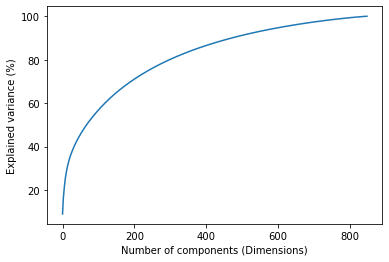

In [14]:
PCA_plot(pca_results[0],pca_results[1])

In [15]:
X_train,X_test,y_train,y_test=normalized_training_test_data(X,y)
X_train,X_test=PCA_transform(X_train,X_test)

In [16]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,-7.416739,-14.797888,64.979208,28.657438,32.562964,-3.413143,20.214267,-14.397126,-7.474690,-35.723427,...,5.128321,4.605355,-6.160281,22.657626,-0.972300,5.323424,2.103992,6.106290,5.884579,-8.482946
1,3.692155,-48.914811,13.859618,36.697031,-26.615922,-40.927171,28.151287,13.168007,-19.210856,-27.571376,...,-16.576601,7.028992,2.800506,25.549495,-2.826083,-5.545334,22.961769,-9.147410,30.305678,-1.466989
2,-50.895025,8.186615,-36.243011,-7.061247,-51.423166,-8.315769,52.687598,-3.230819,46.373605,-34.125558,...,5.588238,-10.504033,-10.436382,0.042743,10.606602,-8.257729,0.568859,-0.011380,-12.610284,-1.094453
3,55.143719,14.028255,58.309691,54.664881,-6.631121,-57.014328,7.913974,-9.569780,17.935273,-18.529812,...,0.857927,0.243431,-2.118881,-2.693516,-3.491969,2.385889,-8.642917,1.315506,-9.454619,2.558268
4,-46.354482,89.673003,-48.489433,-24.826344,-35.294734,-14.662862,-22.932418,28.673144,33.249756,3.095691,...,3.508443,-1.185642,-6.219455,8.857741,1.923027,-2.209162,-5.465943,-1.109806,21.815436,-3.983377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,89.586288,-36.182412,-93.047355,-40.371373,59.827548,-24.649613,-6.858584,-28.411281,32.157847,18.111487,...,-2.492576,0.698092,-0.413319,2.009164,-0.597945,-3.022206,0.909869,0.460477,-2.502243,0.886220
590,-74.919075,-1.473243,-59.685247,0.092437,-13.016628,14.217872,-0.602649,11.611408,41.871262,14.702166,...,-0.932971,-19.381192,3.607783,-10.408097,3.420963,-3.623495,-11.300223,14.164924,9.554828,10.303715
591,-1.900375,53.147558,-33.299876,-40.434839,-50.342680,4.760399,94.555992,58.975669,32.791472,1.332389,...,-15.389133,-8.347935,-8.492746,10.764935,-7.844384,6.808689,-8.852846,3.107281,-9.731962,6.723272
592,122.317960,10.846275,-62.053891,144.789085,43.249673,72.559692,26.072739,-32.396553,-9.304202,-20.122835,...,3.898225,-0.410235,-2.095602,3.160076,4.403811,-0.722983,-3.058942,5.098098,3.635141,-1.072825


In [17]:
logistic_filename,svm_filename,rforest_filename="logistic_result","svm_result","rforest_result"

In [18]:
#training model
logistic_result=logistic_tuner_model(X_train,X_test,y_train,y_test)
save_pickle(logistic_result,logistic_filename,results_folder)

In [19]:
svm_result=svm_tuner_model(X_train,X_test,y_train,y_test)
save_pickle(svm_result,svm_filename,results_folder)

In [20]:
rforest_result=rf_tuner_model(X_train,X_test,y_train,y_test)
save_pickle(rforest_result,rforest_filename,results_folder)

In [21]:
logistic_result=load_pickle(logistic_filename,results_folder)
svm_result=load_pickle(svm_filename,results_folder)
rforest_result=load_pickle(rforest_filename,results_folder)

Best model performance: 0.786806 using {'solver': 'saga', 'C': 0.01}
Model fit and testing time: 0.12seconds 

0.737464 (0.025828) with: {'solver': 'lbfgs', 'C': 10}
0.755277 (0.024652) with: {'solver': 'lbfgs', 'C': 0.01}
0.737176 (0.027589) with: {'solver': 'lbfgs', 'C': 100}
0.778466 (0.021544) with: {'solver': 'sag', 'C': 1.0}
0.778123 (0.021773) with: {'solver': 'sag', 'C': 0.01}
0.753775 (0.017731) with: {'solver': 'liblinear', 'C': 0.01}
0.743911 (0.023071) with: {'solver': 'liblinear', 'C': 0.1}
0.737843 (0.022211) with: {'solver': 'newton-cg', 'C': 10}
0.786691 (0.023788) with: {'solver': 'saga', 'C': 10}
0.742948 (0.024575) with: {'solver': 'lbfgs', 'C': 0.1}
0.778466 (0.021544) with: {'solver': 'sag', 'C': 100}
0.778523 (0.021528) with: {'solver': 'sag', 'C': 0.1}
0.739331 (0.021851) with: {'solver': 'newton-cg', 'C': 1.0}
0.778466 (0.021544) with: {'solver': 'sag', 'C': 10}
0.786806 (0.023653) with: {'solver': 'saga', 'C': 0.01}
0.744994 (0.021965) with: {'solver': 'newton-

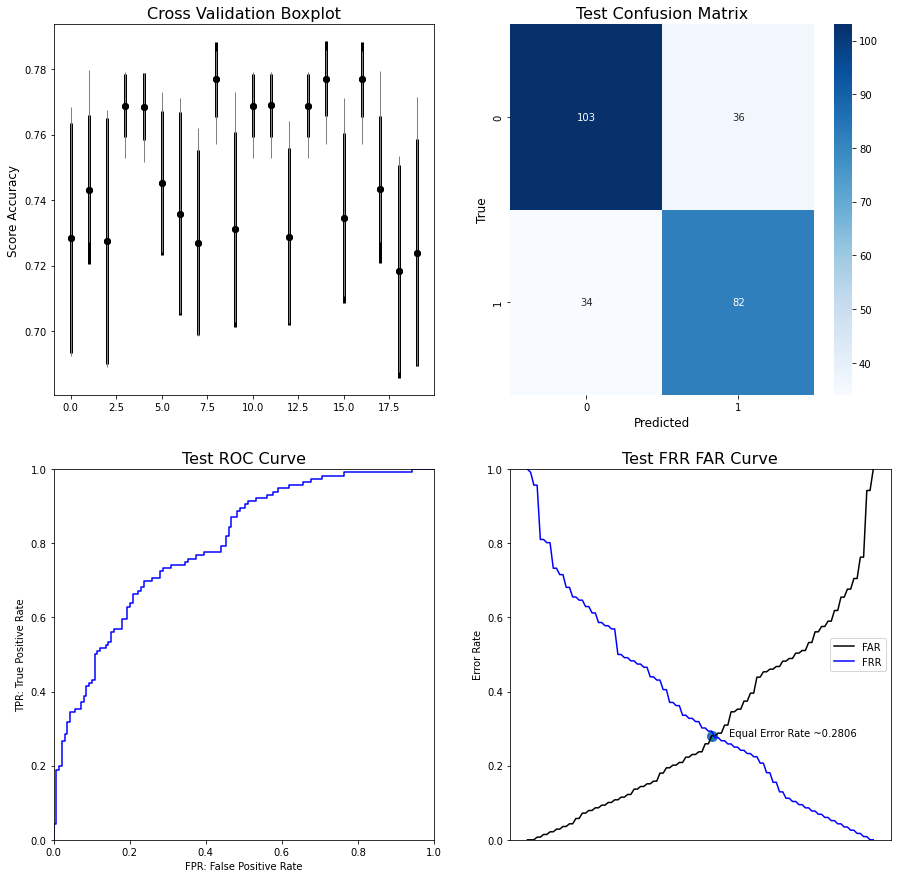

In [22]:
classifier_analysis(logistic_result)

Best model performance: 0.789407 using {'kernel': 'poly', 'gamma': 10, 'C': 1000}
Model fit and testing time: 1.17seconds 

0.500000 (0.000000) with: {'kernel': 'rbf', 'gamma': 1, 'C': 0.1}
0.789407 (0.031857) with: {'kernel': 'poly', 'gamma': 10, 'C': 1000}
0.789407 (0.031857) with: {'kernel': 'poly', 'gamma': 1, 'C': 0.001}
0.789407 (0.031857) with: {'kernel': 'poly', 'gamma': 10, 'C': 1}
0.589744 (0.023540) with: {'kernel': 'sigmoid', 'gamma': 0.01, 'C': 0.001}
0.507004 (0.055820) with: {'kernel': 'sigmoid', 'gamma': 0.001, 'C': 1}
0.504764 (0.056791) with: {'kernel': 'sigmoid', 'gamma': 0.001, 'C': 1000}
0.789407 (0.031857) with: {'kernel': 'poly', 'gamma': 0.1, 'C': 1000}
0.500000 (0.000000) with: {'kernel': 'rbf', 'gamma': 100, 'C': 0.1}
0.510598 (0.056317) with: {'kernel': 'sigmoid', 'gamma': 0.1, 'C': 1000}
0.500000 (0.000000) with: {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.1}
0.500414 (0.061059) with: {'kernel': 'sigmoid', 'gamma': 1000, 'C': 100}
0.789407 (0.031857) with: {'ker

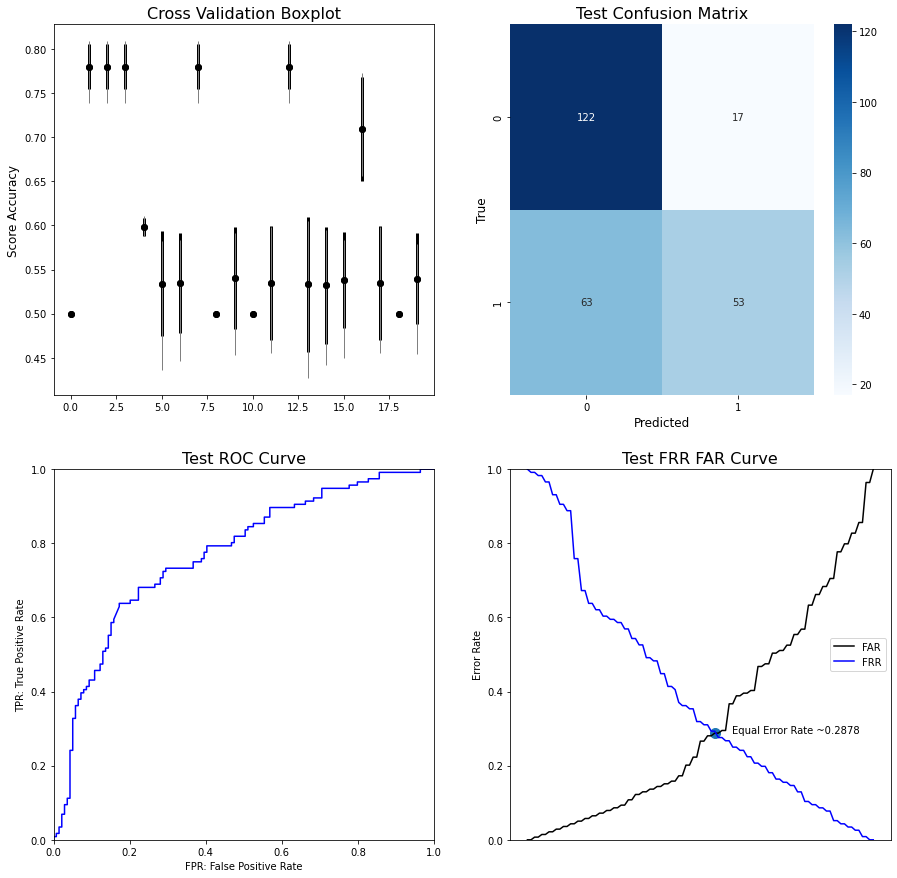

In [23]:
classifier_analysis(svm_result)

Best model performance: 0.777182 using {'n_estimators': 800, 'max_features': 'auto', 'max_depth': 16, 'criterion': 'entropy'}
Model fit and testing time: 1.84seconds 

0.767391 (0.047678) with: {'n_estimators': 600, 'max_features': 'log2', 'max_depth': 12, 'criterion': 'entropy'}
0.750508 (0.018968) with: {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'entropy'}
0.777182 (0.024356) with: {'n_estimators': 800, 'max_features': 'auto', 'max_depth': 16, 'criterion': 'entropy'}
0.740087 (0.034330) with: {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 16, 'criterion': 'gini'}
0.770582 (0.031287) with: {'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
0.764844 (0.027069) with: {'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'gini'}
0.752206 (0.024765) with: {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'entropy'}
0.748261 (0.022853) with: {'n_estimators': 200, '

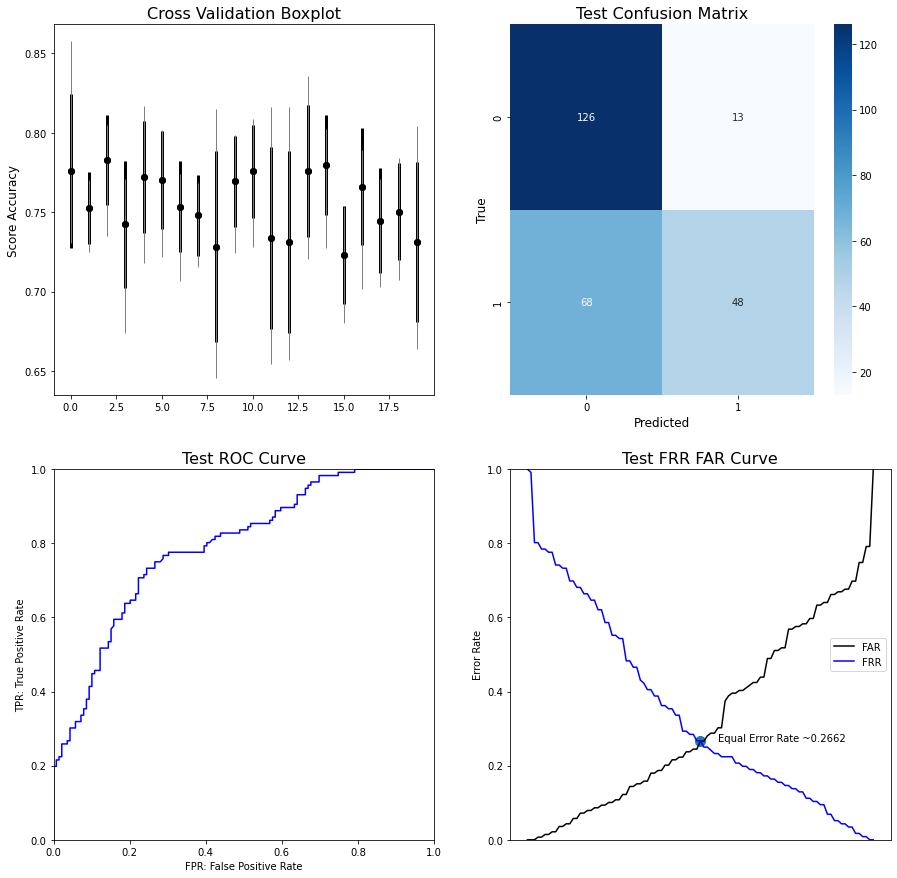

In [24]:
classifier_analysis(rforest_result)